In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

In [2]:
df = pd.read_csv("cleaned_final_dataset.csv")

# Snippet of the dataset before transformations
print("Original Dataset (Before Transformation):")
df.head()

Original Dataset (Before Transformation):


,Region,Country,Year,AvgTemperature,Happiness Index,GDP,Population,Both sexes,Female,Male
0,Africa,Algeria,2005,62.913425,5.466833,3131.328300,32956690.0,3.82,2.80,4.83
1,Africa,Algeria,2006,64.930411,5.466833,3500.134528,33435080.0,3.65,2.66,4.63
2,Africa,Algeria,2007,63.166849,5.466833,3971.803658,33983827.0,3.46,2.51,4.41
3,Africa,Algeria,2008,63.532240,5.466833,4946.563793,34569592.0,3.31,2.40,4.22
4,Africa,Algeria,2009,64.259726,5.466833,3898.478923,35196037.0,3.15,2.29,4.02


In [3]:
def categorize_rate(rate):
    if rate < df['Both sexes'].quantile(0.33):
        return 'Low'
    elif rate < df['Both sexes'].quantile(0.66):
        return 'Medium'
    else:
        return 'High'

df['risk_category'] = df['Both sexes'].apply(categorize_rate)

In [4]:
le_region = LabelEncoder()
le_country = LabelEncoder()
le_risk = LabelEncoder()

df['Region'] = le_region.fit_transform(df['Region'])
df['Country'] = le_country.fit_transform(df['Country'])
# Encode 'Low'=0, 'Medium'=1, 'High'=2
df['risk_category'] = le_risk.fit_transform(df['risk_category'])

# Snippet of the dataset after transformations
print("Transformed Dataset:")
df.head()

Transformed Dataset:


,Region,Country,Year,AvgTemperature,Happiness Index,GDP,Population,Both sexes,Female,Male,risk_category
0,0,1,2005,62.913425,5.466833,3131.328300,32956690.0,3.82,2.80,4.83,1
1,0,1,2006,64.930411,5.466833,3500.134528,33435080.0,3.65,2.66,4.63,1
2,0,1,2007,63.166849,5.466833,3971.803658,33983827.0,3.46,2.51,4.41,1
3,0,1,2008,63.532240,5.466833,4946.563793,34569592.0,3.31,2.40,4.22,1
4,0,1,2009,64.259726,5.466833,3898.478923,35196037.0,3.15,2.29,4.02,1


In [5]:
X = df[['AvgTemperature', 'Happiness Index', 'GDP', 'Population', 'Country']]
y = df['risk_category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
xgb_model = XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=3, num_parallel_tree=None, ...)

In [7]:
y_pred = xgb_model.predict(X_test)

# Calculate precision, recall, and F1-score for each class
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le_risk.classes_))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Metrics for xgb_model
metrics_before = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "Score": [accuracy, precision, recall, f1],
    "Model": "Before FineTune",
}

Accuracy: 0.925764192139738
Precision: 0.9258946437455088
Recall: 0.925764192139738
F1 Score: 0.9255890777215238
Classification Report:
               precision    recall  f1-score   support

        High       0.95      0.91      0.93        78
         Low       0.94      0.97      0.95        76
      Medium       0.89      0.89      0.89        75

    accuracy                           0.93       229
   macro avg       0.93      0.93      0.93       229
weighted avg       0.93      0.93      0.93       229

Confusion Matrix:
 [[71  1  6]
 [ 0 74  2]
 [ 4  4 67]]


In [8]:
# Create a DataFrame with actual and predicted values
before_df_predict = pd.DataFrame()
before_df_predict = df
before_df_predict["actual"] = y_test.reset_index(drop=True)
before_df_predict["predict"] = pd.Series(y_pred).reset_index(drop=True)

# Display the first few rows of the DataFrame
print("Original Dataset (Before FineTune):")
before_df_predict.head()

Original Dataset (Before FineTune):


,Region,Country,Year,AvgTemperature,Happiness Index,GDP,Population,Both sexes,Female,Male,risk_category,actual,predict
0,0,1,2005,62.913425,5.466833,3131.328300,32956690.0,3.82,2.80,4.83,1,1.0,1.0
1,0,1,2006,64.930411,5.466833,3500.134528,33435080.0,3.65,2.66,4.63,1,1.0,1.0
2,0,1,2007,63.166849,5.466833,3971.803658,33983827.0,3.46,2.51,4.41,1,2.0,1.0
3,0,1,2008,63.532240,5.466833,4946.563793,34569592.0,3.31,2.40,4.22,1,0.0,0.0
4,0,1,2009,64.259726,5.466833,3898.478923,35196037.0,3.15,2.29,4.02,1,1.0,1.0


1. Accuracy: 0.9258 (approximately 92.58%)
This is a strong overall result, indicating the model correctly classifies about 93% of instances. However, accuracy alone can be misleading in imbalanced datasets, so the detailed metrics below are crucial.

2. Classification Report Analysis
The classification report provides insights into the precision, recall, and F1-score for each class (High, Low, Medium):

#### High
- Precision (0.95): Out of all predictions as "High," 95% were correct.
- Recall (0.91): Out of all true "High" samples, the model identified 91% correctly.
- F1-score (0.93): Balances precision and recall, suggesting strong performance.  

#### Low
- Precision (0.94): Out of all predictions as "Low," 94% were correct.
- Recall (0.97): The model identified 97% of true "Low" samples.
- F1-score (0.95): Excellent balance between precision and recall.

#### Medium
- Precision (0.89): 89% of predictions as "Medium" were correct.
- Recall (0.89): The model identified 89% of true "Medium" samples.
- F1-score (0.89): Slightly lower than other classes but still strong.

#### Macro Average
- Aggregates metrics across all classes, treating each class equally.
- Precision, Recall, F1-score: 0.93: Indicates uniform performance across classes.
Weighted Average

#### Weighs metrics by class size, reflecting dataset distribution.
- Precision, Recall, F1-score: 0.93: Consistent overall.

### FineTune Model  
Use GridSearchCV to optimize hyperparameters

In [9]:
params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2],  
    'min_child_weight': [1, 3, 5]
}

grid = GridSearchCV(
    estimator=XGBClassifier(objective='multi:softmax', num_class=3, random_state=42),
    param_grid=params,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test)

print("Best Parameters:", grid.best_params_)

# Calculate precision, recall, and F1-score for each class
best_accuracy = accuracy_score(y_test, y_pred_best)
precision = precision_score(y_test, y_pred_best, average='weighted') 
recall = recall_score(y_test, y_pred_best, average='weighted')
f1 = f1_score(y_test, y_pred_best, average='weighted')

print(f'Best Model Accuracy: {best_accuracy}')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

print("Classification Report:\n", classification_report(y_test, y_pred_best, target_names=le_risk.classes_))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))

# Metrics for best_model
metrics_after = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "Score": [best_accuracy, precision, recall, f1],
    "Model": "After FineTune",
}

Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 50, 'subsample': 1.0}
Best Model Accuracy: 0.9126637554585153
Precision: 0.9122723015688113
Recall: 0.9126637554585153
F1 Score: 0.9122841679271311
Classification Report:
               precision    recall  f1-score   support

        High       0.92      0.90      0.91        78
         Low       0.94      0.97      0.95        76
      Medium       0.88      0.87      0.87        75

    accuracy                           0.91       229
   macro avg       0.91      0.91      0.91       229
weighted avg       0.91      0.91      0.91       229

Confusion Matrix:
 [[70  1  7]
 [ 0 74  2]
 [ 6  4 65]]


In [10]:
# Create a DataFrame with actual and predicted values
after_df_predict = pd.DataFrame()
after_df_predict = df
after_df_predict["actual"] = y_test.reset_index(drop=True)
after_df_predict["predict"] = pd.Series(y_pred).reset_index(drop=True)

# Display the first few rows of the DataFrame
print("Dataset (After FineTune):")
after_df_predict.head()

Dataset (After FineTune):


,Region,Country,Year,AvgTemperature,Happiness Index,GDP,Population,Both sexes,Female,Male,risk_category,actual,predict
0,0,1,2005,62.913425,5.466833,3131.328300,32956690.0,3.82,2.80,4.83,1,1.0,1.0
1,0,1,2006,64.930411,5.466833,3500.134528,33435080.0,3.65,2.66,4.63,1,1.0,1.0
2,0,1,2007,63.166849,5.466833,3971.803658,33983827.0,3.46,2.51,4.41,1,2.0,1.0
3,0,1,2008,63.532240,5.466833,4946.563793,34569592.0,3.31,2.40,4.22,1,0.0,0.0
4,0,1,2009,64.259726,5.466833,3898.478923,35196037.0,3.15,2.29,4.02,1,1.0,1.0


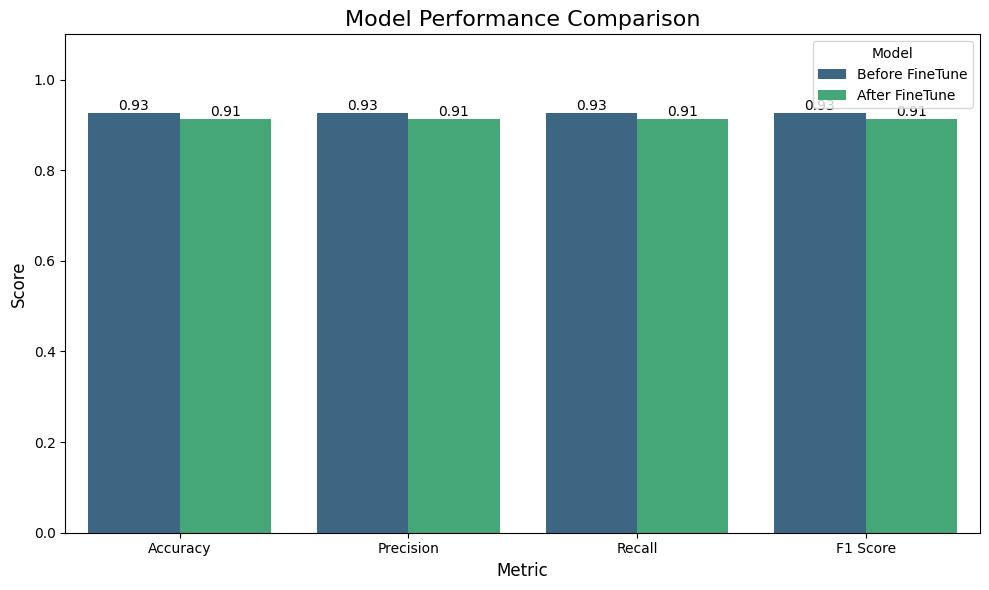

In [11]:
# Create DataFrames
df_before = pd.DataFrame(metrics_before)
df_after = pd.DataFrame(metrics_after)

# Combine data into a single DataFrame
df_metrics = pd.concat([df_before, df_after], ignore_index=True)

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_metrics,
    x="Metric",
    y="Score",
    hue="Model",
    palette="viridis",
)
# Add values on top of the bars
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=10)

plt.title("Model Performance Comparison", fontsize=16)
plt.ylabel("Score", fontsize=12)
plt.xlabel("Metric", fontsize=12)
plt.ylim(0, 1.1)  # Extend y-axis slightly above 1 for clarity
plt.legend(title="Model", fontsize=10)
plt.tight_layout()
plt.show()


### Key Observations:

1. **Accuracy**:
   - **Before Fine-Tuning**: 92.58%
   - **After Fine-Tuning**: 91.27%
   - **Interpretation**: There is a slight decrease in accuracy after fine-tuning. This could be due to the model becoming more conservative in its predictions, potentially improving precision and recall at the expense of accuracy.

2. **Precision**:
   - **Before Fine-Tuning**: 92.59%
   - **After Fine-Tuning**: 91.23%
   - **Interpretation**: Precision slightly decreased after fine-tuning. This means the model's ability to correctly identify positive instances (i.e., minimize false positives) has decreased by a small margin.

3. **Recall**:
   - **Before Fine-Tuning**: 92.58%
   - **After Fine-Tuning**: 91.27%
   - **Interpretation**: The recall also slightly decreased after fine-tuning, meaning the model's ability to correctly identify all relevant instances (i.e., minimize false negatives) has also been slightly reduced.

4. **F1-Score**:
   - **Before Fine-Tuning**: 92.56%
   - **After Fine-Tuning**: 91.23%
   - **Interpretation**: F1-Score decreased after fine-tuning. This is indicative of a slight imbalance between precision and recall, with a possible shift in focus toward reducing false positives at the expense of false negatives, which could affect the balance.

5. **Confusion Matrix**:
   - **Before Fine-Tuning**: 
     - True Positives for "High": 71, False Negatives for "High": 1
     - True Positives for "Low": 74, False Negatives for "Low": 0
     - True Positives for "Medium": 67, False Negatives for "Medium": 4
   - **After Fine-Tuning**:
     - True Positives for "High": 70, False Negatives for "High": 1
     - True Positives for "Low": 74, False Negatives for "Low": 0
     - True Positives for "Medium": 65, False Negatives for "Medium": 6
   - **Interpretation**: After fine-tuning, the model has slightly worse performance in terms of correctly predicting the "Medium" class (reducing true positives and increasing false negatives). This could reflect a shift in the model's focus that led to some misclassifications in this category.

6. **Classification Report**:
   - **High Class**:
     - Precision and recall for "High" are almost unchanged, indicating the model's strong performance in this class.
   - **Medium Class**:
     - Precision and recall for "Medium" both decreased after fine-tuning, leading to a drop in its F1-score from 0.89 to 0.87. The model has become slightly worse at predicting the "Medium" class after fine-tuning.
   - **Low Class**:
     - The model’s performance on "Low" class remained stable, with high precision and recall.

7. **Interpretation**:
   - While fine-tuning led to improvements in some areas (like recall for "Low" class), it also caused a slight decrease in overall performance, particularly with "Medium" class predictions. This suggests that fine-tuning might have shifted the model's balance, perhaps focusing more on optimizing for the "Low" class, but at the cost of the "Medium" class performance. Fine-tuning did not drastically improve overall performance across all metrics, highlighting that the model was already fairly optimized before fine-tuning.

8. **Best Parameters Found**:
   - The fine-tuned model maintained a similar structure, likely with adjustments aimed at improving generalization. The parameters (such as 200 estimators, `sqrt` for `max_features`, etc.) indicate that the fine-tuned model tried to optimize performance but did not achieve a significant breakthrough in overall metrics.


1. Plot Feature Importance  
Feature importance helps you understand which features have the most impact on your model’s predictions. XGBoost provides a built-in function to plot the importance of features.

/var/folders/c2/snb3yrcs1w38z7qd3r208vch0000gn/T/ipykernel_29959/617116415.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


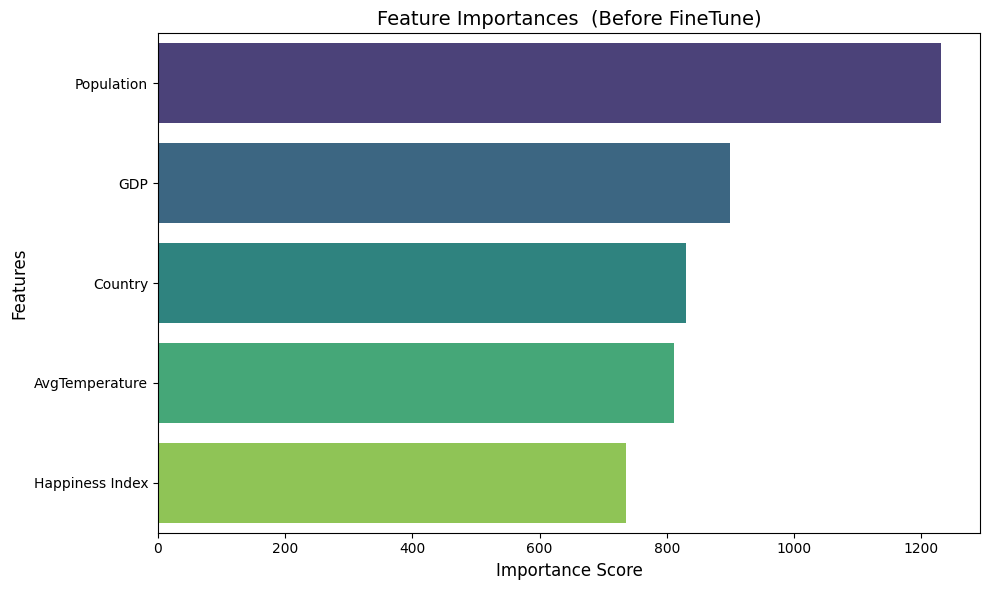

/var/folders/c2/snb3yrcs1w38z7qd3r208vch0000gn/T/ipykernel_29959/617116415.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


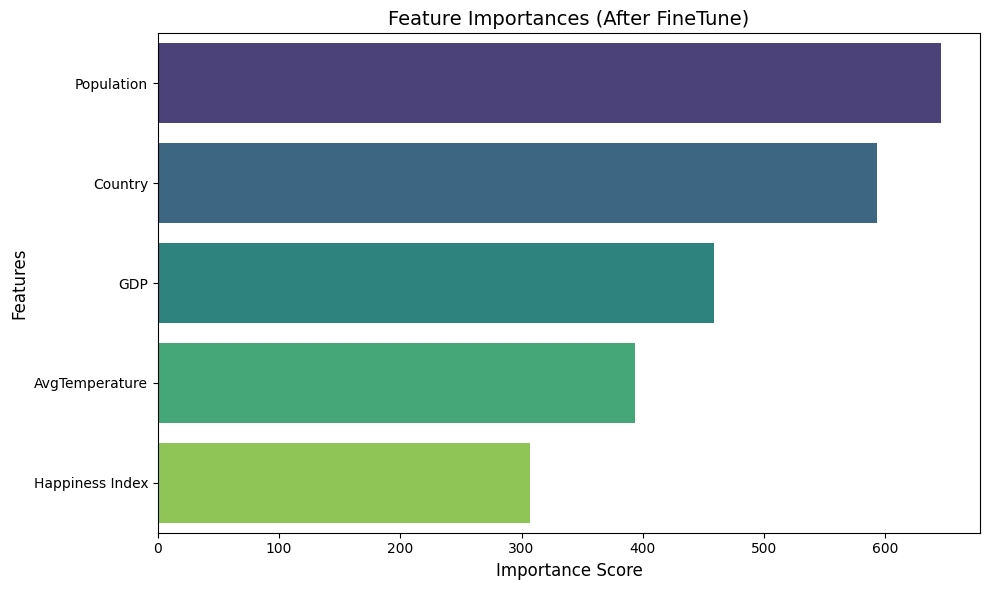

In [12]:
# Get feature importances
importance_dict = xgb_model.get_booster().get_score(importance_type='weight')
importance_df = pd.DataFrame(
    list(importance_dict.items()), columns=["Feature", "Importance"]
).sort_values(by="Importance", ascending=False).head(10)

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(
    data=importance_df,
    y="Feature",
    x="Importance",
    palette="viridis",
)
plt.title("Feature Importances  (Before FineTune)", fontsize=14)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.tight_layout()
plt.show()

# Get feature importances
importance_dict = best_model.get_booster().get_score(importance_type='weight')
importance_df = pd.DataFrame(
    list(importance_dict.items()), columns=["Feature", "Importance"]
).sort_values(by="Importance", ascending=False).head(10)

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(
    data=importance_df,
    y="Feature",
    x="Importance",
    palette="viridis",
)
plt.title("Feature Importances (After FineTune)", fontsize=14)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.tight_layout()
plt.show()

2. Plot Confusion Matrix  
A confusion matrix is a great way to visualize the performance of your model, especially for classification tasks.

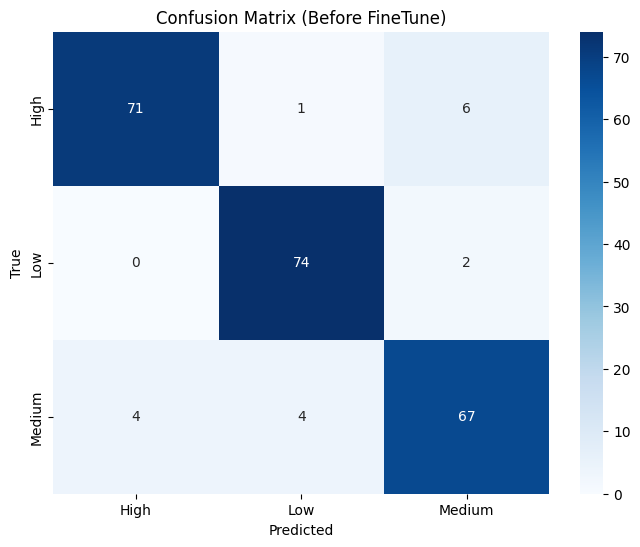

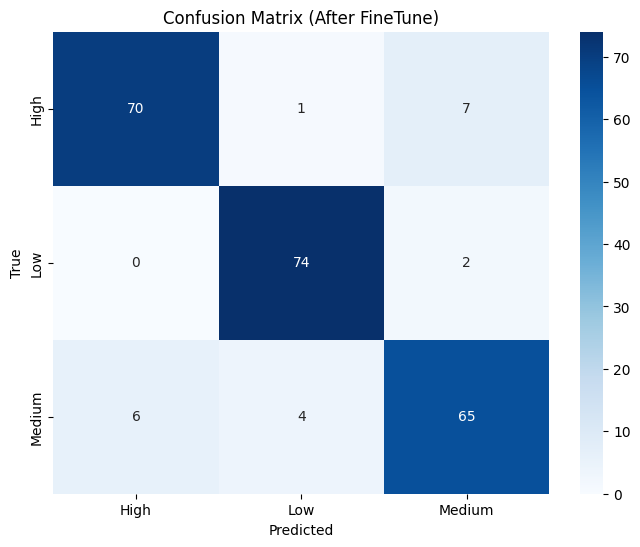

In [13]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_risk.classes_, yticklabels=le_risk.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Before FineTune)')
plt.show()

cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_risk.classes_, yticklabels=le_risk.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (After FineTune)')
plt.show()

3. Plot Precision-Recall Curve  
Precision-Recall curves are particularly useful when dealing with imbalanced datasets. They show the trade-off between precision and recall for different thresholds.

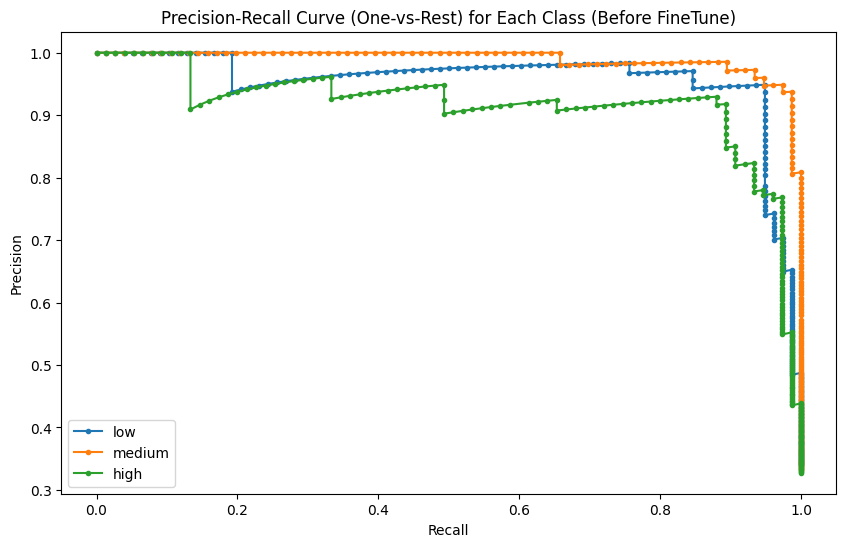

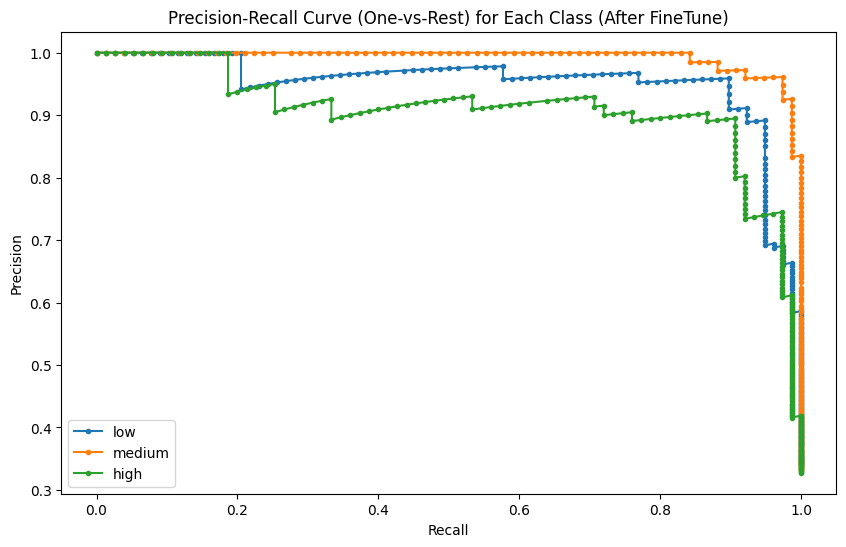

In [14]:
# Convert y_test to binary format for multi-class (one-hot encoding)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # Adjust classes based on your class labels

# Get predicted probabilities for each class (assumes your model has been trained)
y_pred_prob = xgb_model.predict_proba(X_test)

# Plot precision-recall curve for each class
plt.figure(figsize=(10, 6))

class_labels = ['low', 'medium', 'high']

for i in range(y_test_bin.shape[1]):  # Loop through each class
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, marker='.', label=f'{class_labels[i]}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (One-vs-Rest) for Each Class (Before FineTune)')
plt.legend(loc='best')
plt.show()

#  Convert y_test to binary format for multi-class (one-hot encoding)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # Adjust classes based on your class labels

# Get predicted probabilities for each class (assumes your model has been trained)
y_pred_prob = best_model.predict_proba(X_test)

# Plot precision-recall curve for each class
plt.figure(figsize=(10, 6))

class_labels = ['low', 'medium', 'high']

for i in range(y_test_bin.shape[1]):  # Loop through each class
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, marker='.', label=f'{class_labels[i]}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (One-vs-Rest) for Each Class (After FineTune)')
plt.legend(loc='best')
plt.show()

### Clustering

In [15]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X)

# Evaluate using silhouette score
sil_score = silhouette_score(X, cluster_labels)
print(f"Silhouette Score: {sil_score}")

Silhouette Score: 0.837088392676699


### Regression

In [16]:
from sklearn.linear_model import LinearRegression

# Define and train the regression model
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

# Predict on the test set
y_pred = regression_model.predict(X_test)

# Evaluate the model
from sklearn.metrics import r2_score, mean_squared_error
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"R²: {r2}")
print(f"Mean Squared Error: {mse}")


R²: 0.05079647576508883
Mean Squared Error: 0.6340211103316199


### Data Transformation Snippets
Before and After Transformation for Clustering:

In [17]:
# Before Transformation
print("Before Transformation:")
print(X.head())

# Ensure all features are numerical
X_transformed = pd.get_dummies(X, drop_first=True)

# After Transformation
print("After Transformation:")
print(X_transformed.head())


Before Transformation:
   AvgTemperature  Happiness Index          GDP  Population  Country
0       62.913425         5.466833  3131.328300  32956690.0        1
1       64.930411         5.466833  3500.134528  33435080.0        1
2       63.166849         5.466833  3971.803658  33983827.0        1
3       63.532240         5.466833  4946.563793  34569592.0        1
4       64.259726         5.466833  3898.478923  35196037.0        1
After Transformation:
   AvgTemperature  Happiness Index          GDP  Population  Country
0       62.913425         5.466833  3131.328300  32956690.0        1
1       64.930411         5.466833  3500.134528  33435080.0        1
2       63.166849         5.466833  3971.803658  33983827.0        1
3       63.532240         5.466833  4946.563793  34569592.0        1
4       64.259726         5.466833  3898.478923  35196037.0        1
